In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

In [2]:
torch.cuda.is_available()

True

In [3]:
class Digits(Dataset):

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [6]:
train_data = Digits()
test_data = Digits(mode="val")
len(train_data), len(test_data)

(1000, 350)

In [ ]:
train_data[0].shape

(999, 64)

(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

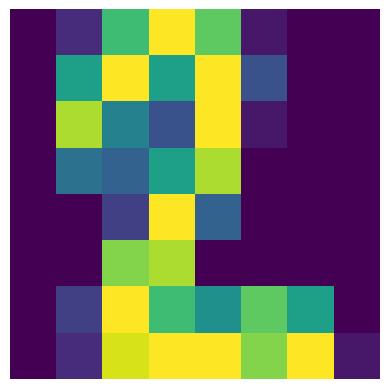

In [28]:
import matplotlib.pyplot as plt
import random

img = train_data[random.choice(range(len(train_data)))].reshape((8,8))
plt.imshow(img)
plt.axis("off")

In [32]:
class MoG(nn.Module):
    def __init__(self, D, K, uniform=False):
        super(MoG, self).__init__()

        # Hyperparameters
        self.uniform = uniform
        self.D = D
        self.K = K

        # Parameters
        self.mu = nn.Parameter(torch.randn(1, self.K, self.D) * 0.25 + 0.5)
        self.log_var = nn.Parameter(-3.0 * torch.ones(1, self.K, self.D))

        if self.uniform:
            self.w = torch.zeros(1, self.K)
            self.w.requires_grad = False
        else:
            self.w = nn.Parameter(torch.zeros(1, self.K))
        self.PI = torch.from_numpy(np.asarray(np.pi))

    def log_diag_normal(self, x, mu, log_var, reduction="sum", dim=1):
        log_p = (
            -0.5 * torch.log(2.0 * self.PI)
            - 0.5 * log_var
            - 0.5 * torch.exp(-log_var) * (x.unsqueeze(1) - mu) ** 2.0
        )
        return log_p

    def forward(self, x, reduction="mean"):
        log_pi = torch.log(
            F.softmax(self.w, 1)
        ) 
        log_N = torch.sum(self.log_diag_normal(x, self.mu, self.log_var), 2)
        NLL_loss = -torch.logsumexp(log_pi + log_N, 1)  # B

        if reduction == "sum":
            return NLL_loss.sum()
        elif reduction == "mean":
            return NLL_loss.mean()
        else:
            raise ValueError("Either `sum` or `mean`.")

    def sample(self, batch_size=64):
        x_sample = torch.empty(batch_size, self.D)

        pi = F.softmax(
            self.w, 1
        )

        indices = torch.multinomial(pi, batch_size, replacement=True).squeeze()

        for n in range(batch_size):
            indx = indices[n]
            x_sample[n] = self.mu[0, indx] + torch.exp(
                0.5 * self.log_var[0, indx]
            ) * torch.randn(self.D)

        return x_sample
    
    def log_prob(self, x, reduction='mean'):
        with torch.no_grad():
            log_pi = torch.log(F.softmax(self.w, 1)) 
            log_N = torch.sum(self.log_diag_normal(x, self.mu, self.log_var), 2)  
        
            log_prob = torch.logsumexp(log_pi + log_N,  1) 
            
            if reduction == 'sum':
                return log_prob.sum()
            elif reduction == 'mean':
                return log_prob.mean()
            else:
                raise ValueError('Either `sum` or `mean`.')